In [2]:
import mne
from mne.preprocessing import ICA
from pathlib import Path

# 1. Configuration
bids_root = Path(r"C:\Users\noahm\projects\loc_analysis\data\derivatives")
sub_number = "01"
task = "loc"

# Define Paths
deriv_root = bids_root / f"sub-{sub_number}" / "eeg"
fname_in = deriv_root / f"sub-{sub_number}_task-{task}_downsamp-2_eeg.fif"
fname_out = deriv_root / f"sub-{sub_number}_task-{task}_desc-preprocessed_eeg.fif"

print(f"Processing Subject: {sub_number}")
print(f"Input file: {fname_in}")
print(f"Output file: {fname_out}")

Processing Subject: 01
Input file: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif
Output file: C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_desc-preprocessed_eeg.fif


In [3]:
# 2. Load Data
#    MNE will automatically load the 'bads' you marked in the previous script.
raw = mne.io.read_raw_fif(fname_in, preload=True)

# Quick check of info to ensure bads are present
print("Bad channels marked:", raw.info['bads'])
raw.plot(duration=5, n_channels=30, scalings='auto') # Optional sanity check

Opening raw data file C:\Users\noahm\projects\loc_analysis\data\derivatives\sub-01\eeg\sub-01_task-loc_downsamp-2_eeg.fif...
    Range : 0 ... 1554879 =      0.000 ...  3109.758 secs
Ready.
Reading 0 ... 1554879  =      0.000 ...  3109.758 secs...
Bad channels marked: ['AF8']
Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x1e8febcf020) at 0x000001E8E196D100>

Channels marked as bad:
['AF8']


### Filtering

In [30]:
filt_raw = raw_annotated.load_data().filter(l_freq=0.5, h_freq=120.0)

Reading 0 ... 3109759  =      0.000 ...  3109.759 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    3.6s finished


Used Annotations descriptions: ['dist_end', 'dist_start', 'enc_act1', 'enc_act2', 'enc_act3', 'enc_cue', 'enc_fixation', 'enc_prompt', 'enc_resp', 'enc_target', 'encoding_phase_ends', 'encoding_phase_starts', 'new_segment', 'prac_end', 'prac_start', 'ret_cue', 'ret_end', 'ret_instr_start', 'ret_q1_onset', 'ret_q1_resp', 'ret_q2_onset', 'ret_q2_resp', 'ret_q3_onset', 'ret_q3_resp', 'retrieval_phase_starts']
Not setting metadata
1220 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


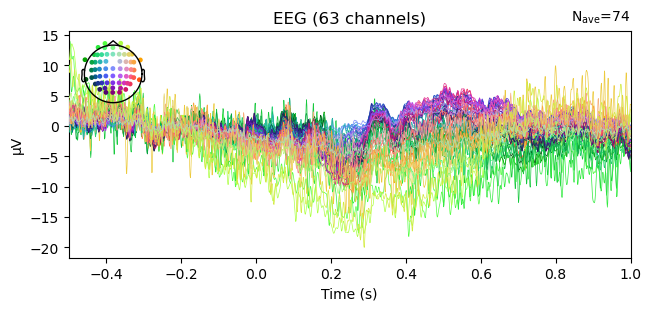

In [31]:
# Have a look at the Evoked potential during experimental event (here Encoding) to check if the filtering has worked
events, event_dict = mne.events_from_annotations(filt_raw)
epochs = mne.Epochs(
    filt_raw,
    events,
    event_id=event_dict,
    tmin=-0.5,
    tmax=1,
    reject_by_annotation=True, # default parameter
)['enc_target'].average().plot()

Notch filter out 50Hz

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 1033851 of 3109760 (33.25%) samples to NaN, retaining 2075909 (66.75%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 400, using nperseg = 400
  return _func(*args, **kwargs)


Plotting power spectral density (dB=True).


/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1645, using nperseg = 1645
  return _func(*args, **kwargs)
/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 521, using nperseg = 521
  return _func(*args, **kwargs)
/Users/ivan_/miniconda3/envs/mne/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


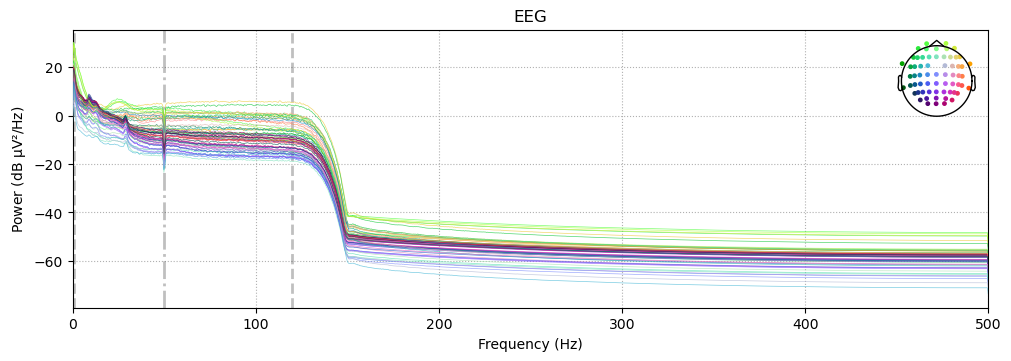

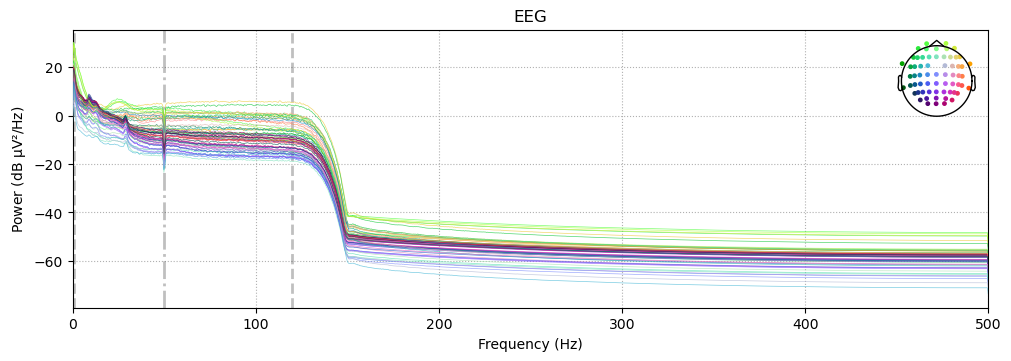

In [32]:
filt_raw.notch_filter(freqs=50, verbose=False)
filt_raw.plot_psd()

In [33]:
filt_raw.plot()

Using pyopengl with version 3.1.9


Channels marked as bad:
none


### ICA for ocular movements

In [34]:
ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Omitting 1033851 of 3109760 (33.25%) samples, retaining 2075909 (66.75%) samples.
Selecting by number: 15 components
Fitting ICA took 30.9s.


<ICA | raw data decomposition, method: fastica (fit in 33 iterations on 2075909 samples), 15 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

In [35]:
ica.plot_sources(filt_raw, show_scrollbars=False)

Creating RawArray with float64 data, n_channels=15, n_times=3109760
    Range : 0 ... 3109759 =      0.000 ...  3109.759 secs
Ready.
Using pyopengl with version 3.1.9


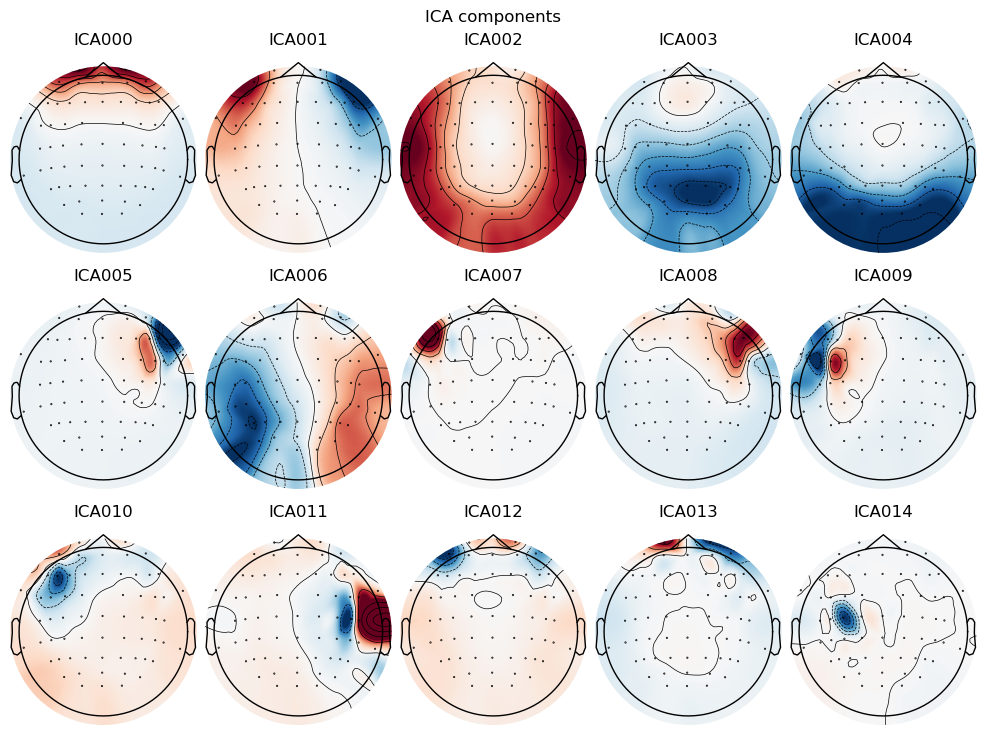

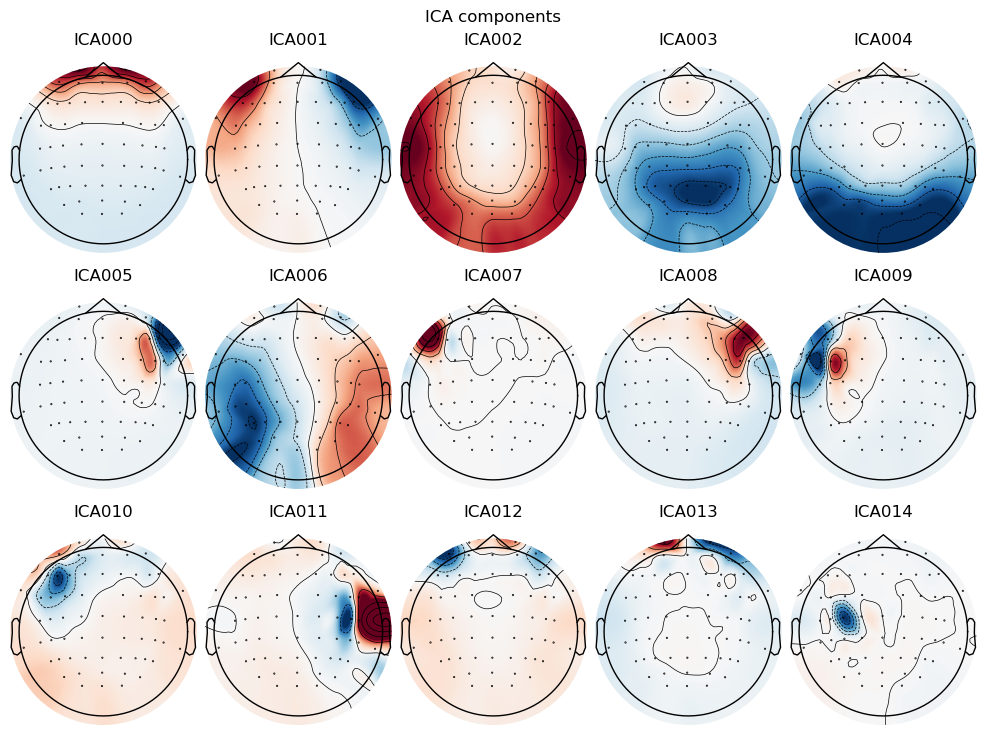

In [36]:
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


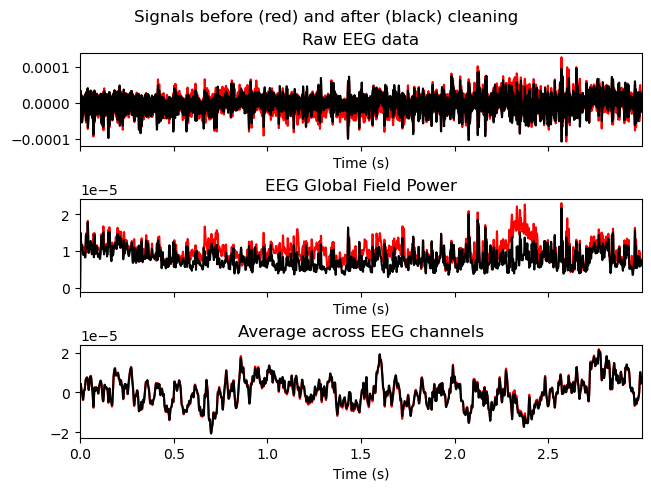

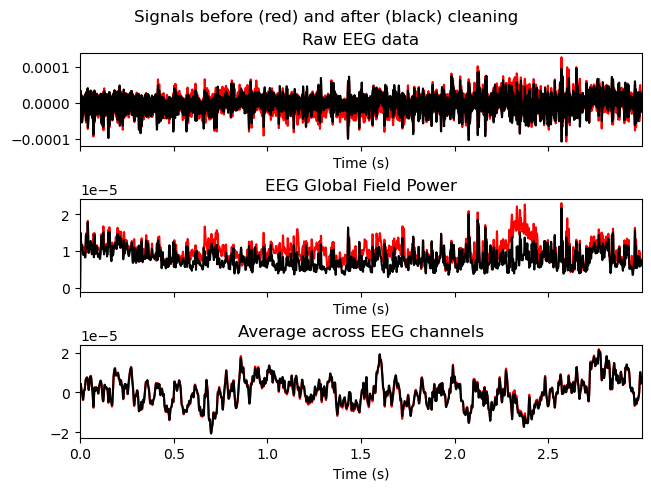

In [37]:
# blinks
ica.plot_overlay(filt_raw, exclude=[0, 1], picks="eeg")

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated


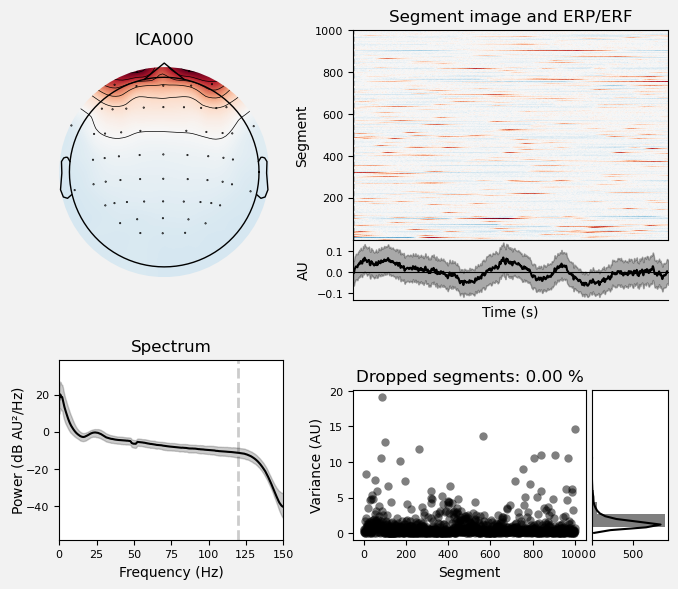

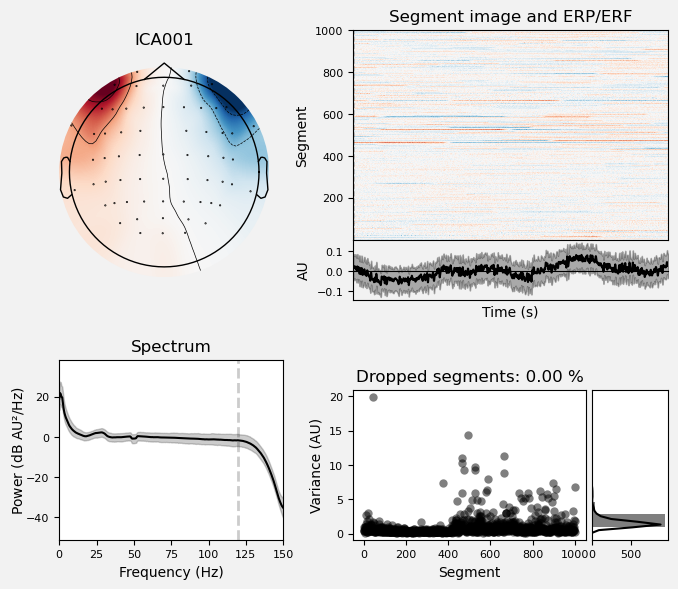

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [38]:
ica.plot_properties(filt_raw, picks=[0, 1])

In [39]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_raw.copy()
ica.exclude = [0, 1]
ica.apply(reconst_raw)
reconst_raw.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
Using pyopengl with version 3.1.9


Channels marked as bad:
none


# Up to here

## Epoching

In [ ]:
# If we want to select epochs based on a condition, we can use the `selection` parameter
# Which is a dictionary with the condition as key and the list of values as value
reject_criteria = dict(
    eeg=150e-6,  # 150 µV
) 

# Create epochs from the raw data
epochs = mne.Epochs(
    reconst_raw, # raw data
    events, # event data
    event_id=event_dict, # dictionary with event names and their corresponding IDs
    tmin=-0.2,
    tmax=0.5, # 200ms before and 500ms after the event
    reject=reject_criteria, # reject epochs based on the criteria - amplitude
    baseline=(None, 0), # apply using pre-stim baseline period
    preload=True, # put into memory
)


Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 421 original time points ...
    Rejecting  epoch based on EEG : ['EEG 008']
10 bad epochs dropped


In [34]:
# Select only the conditions we care about
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
# Equalize the number of epochs in each condition
epochs.equalize_event_counts(conds_we_care_about, method='random', random_state=42)  # this operates in-place

Dropped 4 epochs: 64, 218, 229, 255


(<Epochs | 306 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~61.9 MB, data loaded,
  'auditory/left': 69
  'auditory/right': 69
  'visual/left': 69
  'visual/right': 69
  'smiley': 14
  'buttonpress': 16>,
 array([229,  64, 218, 255]))

### Rereference to average

In [ ]:
### Rereference to average
# use the average of all channels as reference
epochs_avg_ref = epochs.copy().set_eeg_reference(ref_channels="average")
epochs_avg_ref.plot()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


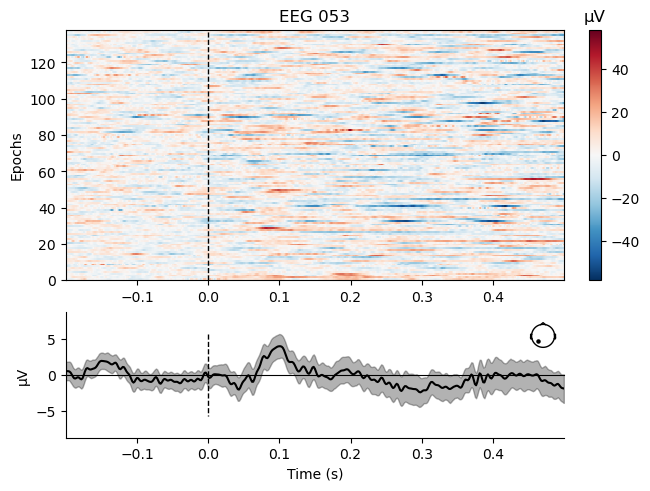

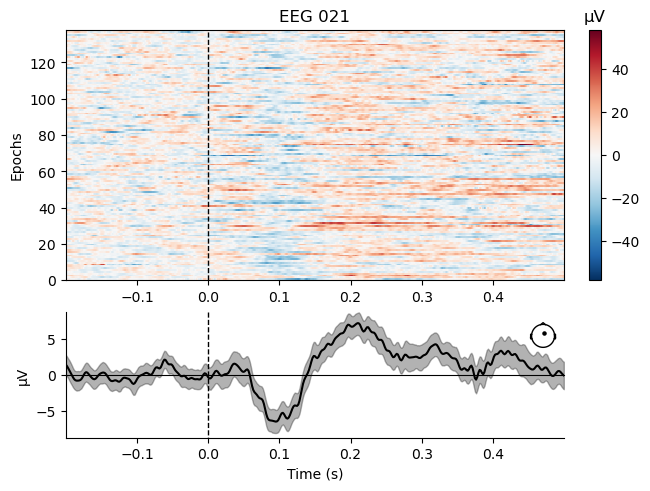

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [37]:
# Get a contrast between auditory and visual conditions
aud_epochs = epochs["auditory"] # Selecting done by the event description (key in the event_dict)
vis_epochs = epochs["visual"]

# Plot the data from the epochs - it is a 3D array
aud_epochs.plot_image(picks=["EEG 053", "EEG 021"])

# ERPs

In [38]:
# Let's average the epochs for each condition
l_aud = epochs["auditory/left"].average()
r_aud = epochs["auditory/right"].average()
l_vis = epochs["visual/left"].average()
r_vis = epochs["visual/right"].average()

No projector specified for this dataset. Please consider the method self.add_proj.


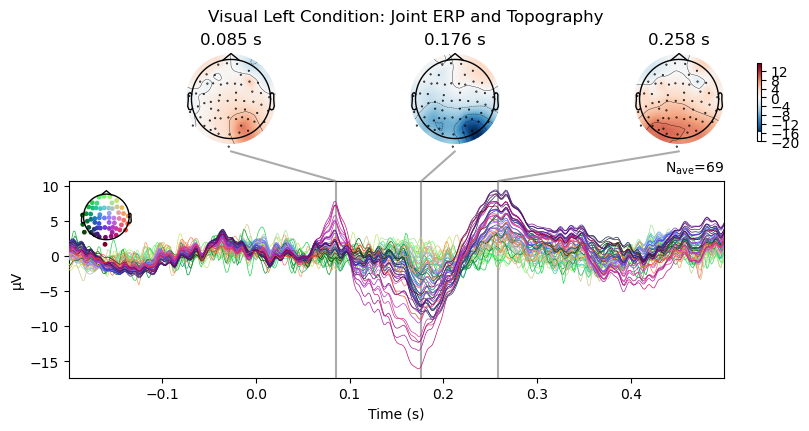

No projector specified for this dataset. Please consider the method self.add_proj.


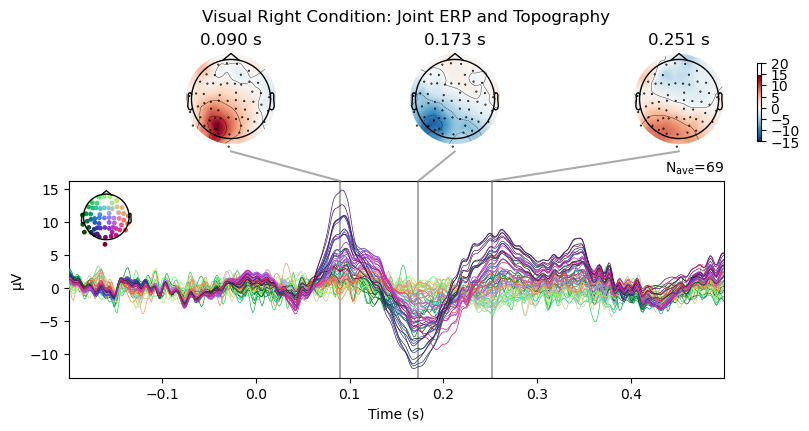

In [39]:
fig1 = l_vis.plot_joint(title="Visual Left Condition: Joint ERP and Topography")
fig2 = r_vis.plot_joint(title="Visual Right Condition: Joint ERP and Topography")

In [ ]:
# Let's compare the difference between two conditions using a seleciton of channels
picks = ['EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014']
evokeds = dict(
    aud_left=list(epochs["auditory/left"].iter_evoked()),
    aud_right=list(epochs["auditory/right"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks)

combining channels using "mean"
combining channels using "mean"


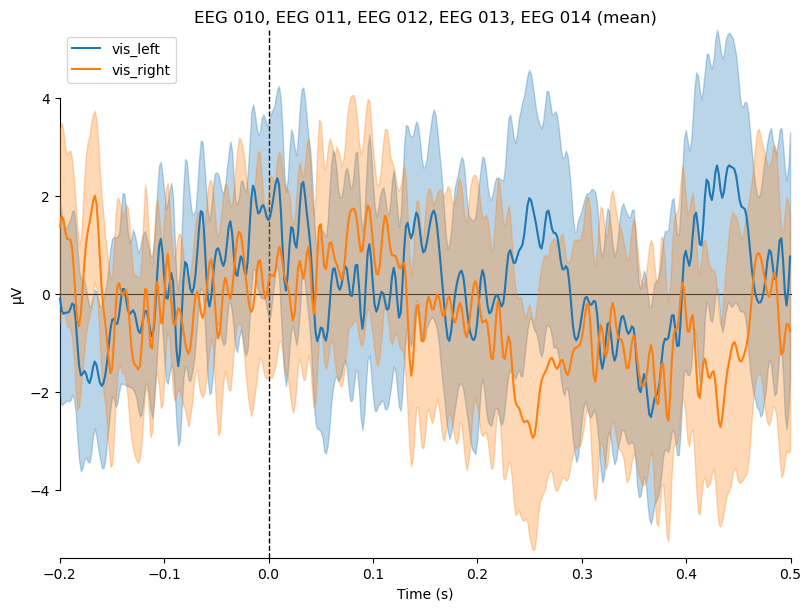

[<Figure size 800x600 with 1 Axes>]

In [40]:
# Let's compare the difference between two conditions using a seleciton of channels
picks = ['EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014']
evokeds = dict(
    vis_left=list(epochs["visual/left"].iter_evoked()),
    vis_right=list(epochs["visual/right"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks)

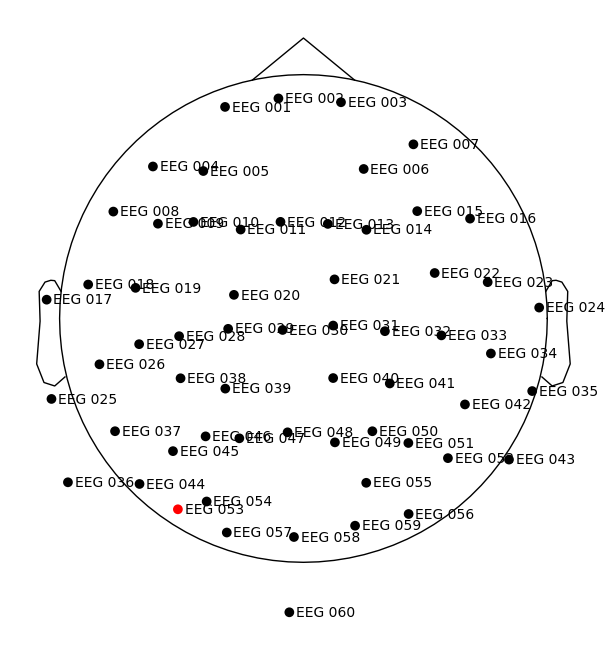

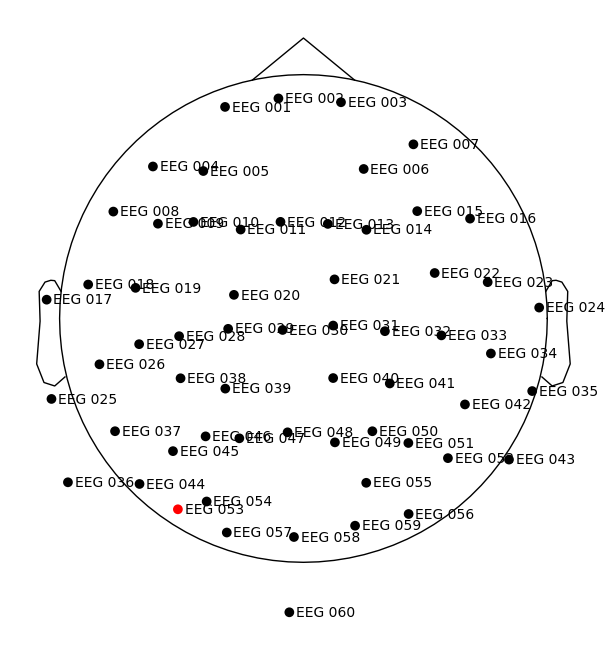

In [42]:
raw.plot_sensors(show_names=True)

In [ ]:
def plot_occipital_channels(raw_data):
    # Define the list of occipital channels
    occipital_channels = [ch for ch in raw_data.ch_names if 'O' in ch]
    
    # Plot the occipital channels
    raw_data.plot(picks=occipital_channels)

# Use the function to plot occipital channels from the raw data
plot_occipital_channels(raw)

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


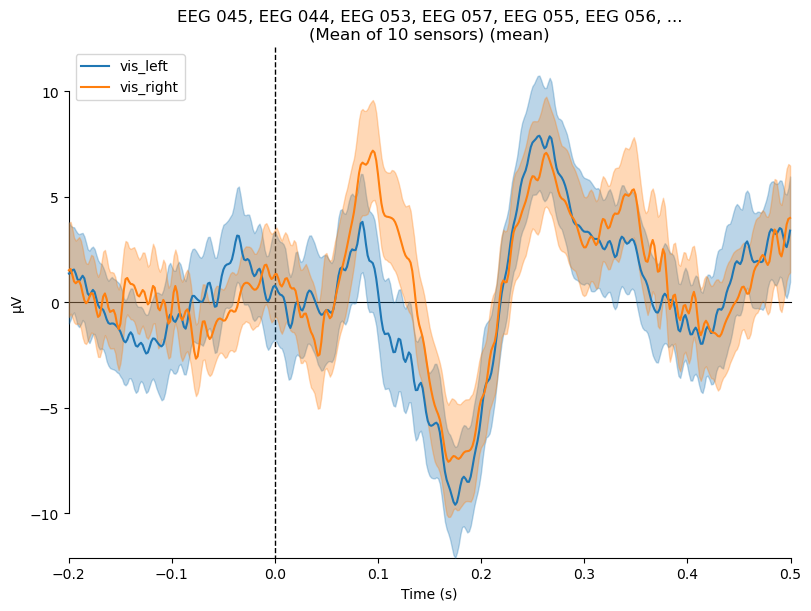

[<Figure size 800x600 with 1 Axes>]

In [ ]:
# Let's compare the difference between two conditions using a seleciton of channels
picks = ['EEG 045', 'EEG 044', 'EEG 053', 'EEG 057', 'EEG 055', 'EEG 056', 'EEG 059','EEG 052', 'EEG 058' , 'EEG 060']
evokeds = dict(
    vis_left=list(epochs["visual/left"].iter_evoked()),
    vis_right=list(epochs["visual/right"].iter_evoked()),
) # Define the evoked data
mne.viz.plot_compare_evokeds(evokeds, combine="mean", picks=picks) # Plot the data

No projector specified for this dataset. Please consider the method self.add_proj.


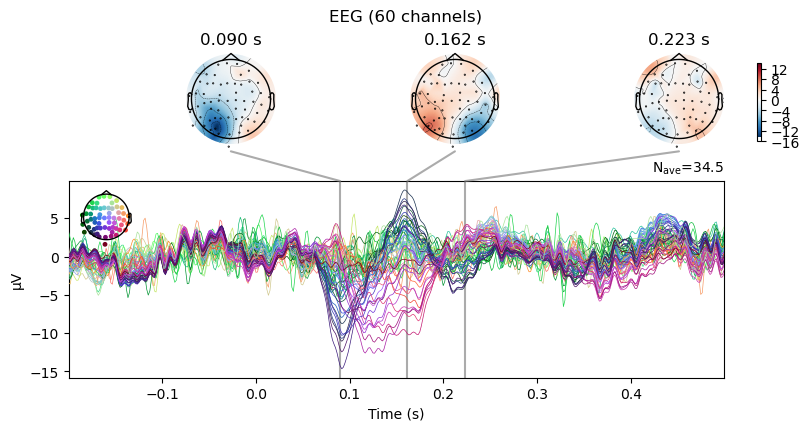

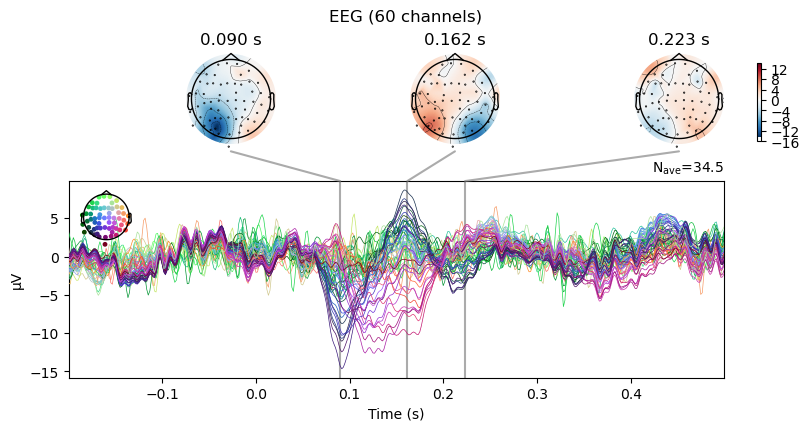

In [43]:
# Plot the subtracted difference: 
aud_minus_vis = mne.combine_evoked([l_vis, r_vis], weights=[1, -1])
aud_minus_vis.plot_joint()

In [ ]:
reconst_raw.save("reconst_raw.fif")

new_reconst_raw = mne.io.read_raw_fif("reconst_raw.fif")

In [44]:
epochs.save("epochs-epo.fif")

#new_epochs = mne.read_epochs("epochs-epo.fif")

# Time-Frequency Analyses

In [ ]:
# Load raw data
data_path = mne.datasets.ssvep.data_path()
bids_fname = (
    data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info["line_freq"] = 50.0

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=100, fir_design="firwin", verbose=False)

# Resample raw data
raw.resample(sfreq=240, verbose=False)

<RawBrainVision | sub-02_ses-01_task-ssvep_eeg.eeg, 32 x 112219 (467.6 s), ~27.4 MB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


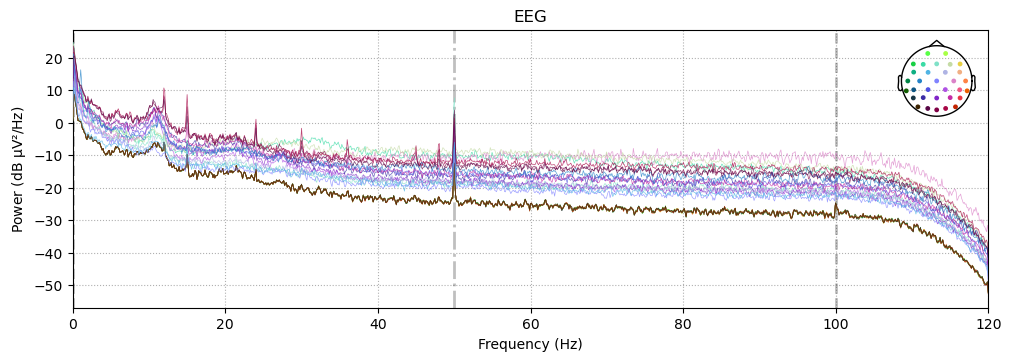

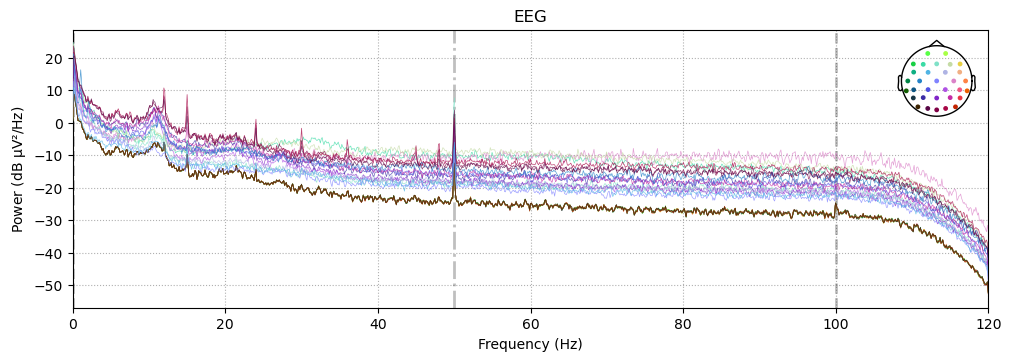

In [46]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


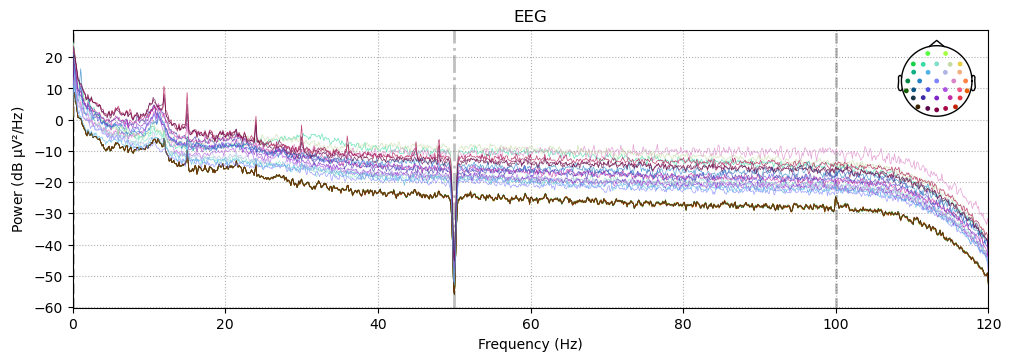

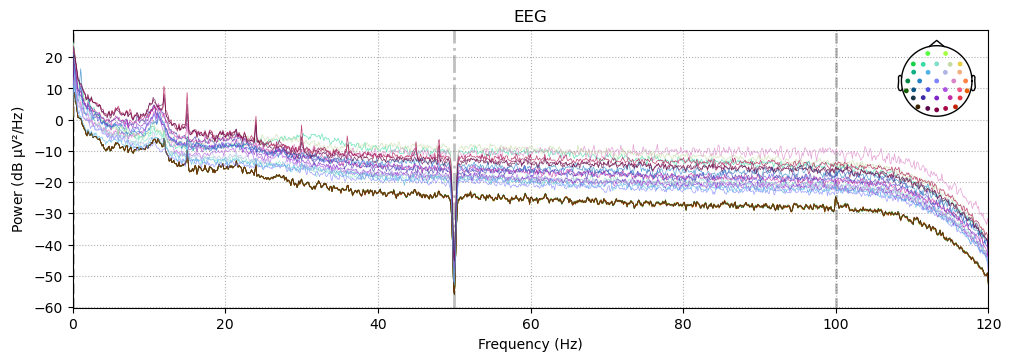

In [47]:
raw.notch_filter(freqs=50, verbose=False)
raw.plot_psd()


In [48]:
# Construct epochs
raw.annotations.rename({"Stimulus/S255": "12hz", "Stimulus/S155": "15hz"})

tmin, tmax = -1.0, 20.0  # in s
baseline = None 
epochs = mne.Epochs(
    raw,
    event_id=["12hz", "15hz"],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    verbose=True,
)
epochs

Used Annotations descriptions: ['12hz', '15hz', 'New Segment/']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


<Epochs | 20 events (good & bad), -1 – 20 s (baseline off), ~44 kB, data not loaded,
 '12hz': 10
 '15hz': 10>

In [ ]:
epochs.plot()

Using data from preloaded Raw for 20 events and 5041 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 2 events and 5041 original time points ...
Using data from preloaded Raw for 20 events and 5041 

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 20 events and 5041 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


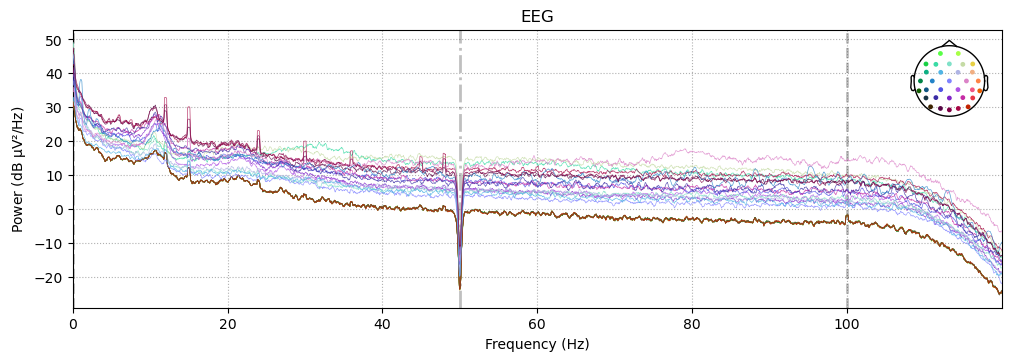

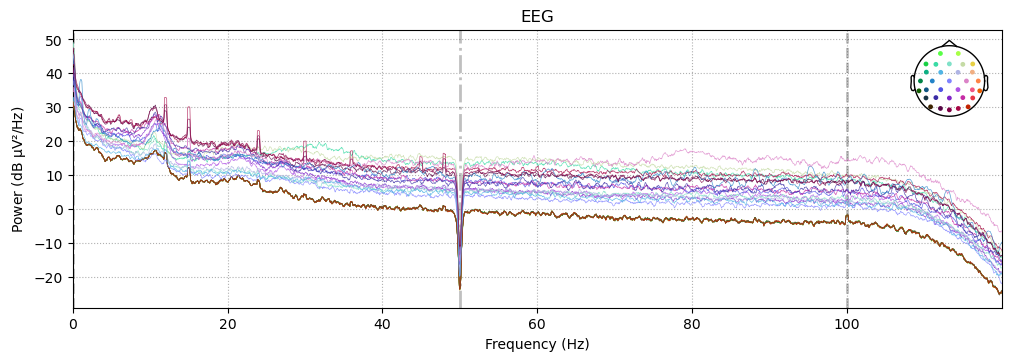

In [50]:
epochs.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 20 events and 5041 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


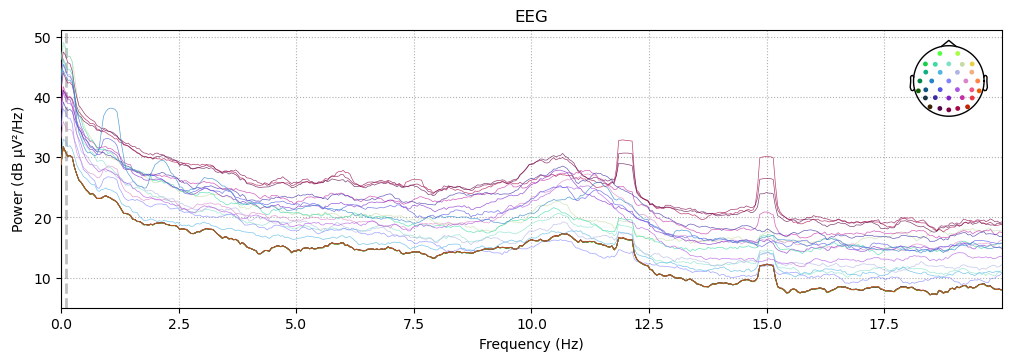

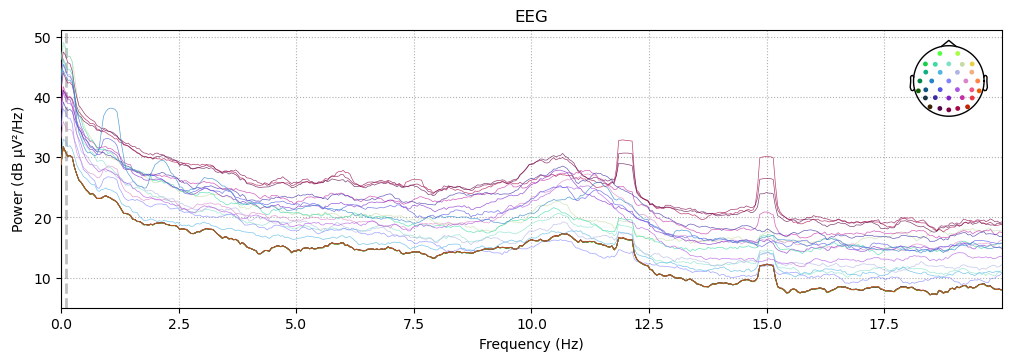

In [51]:
epochs.plot_psd(fmin=0, fmax=20)

In [52]:
epochs_12hz = epochs["12hz"]
epochs_15hz = epochs["15hz"]

In [53]:
frequencies = np.arange(3, 35, 1)
frequencies

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [54]:
frequencies = np.arange(3, 35, 1)
power_12 = epochs_12hz.compute_tfr(
    "morlet", n_cycles=8, return_itc=False, freqs=frequencies, average=True
)

frequencies = np.arange(3, 35, 1)
power_15 = epochs_15hz.compute_tfr(
    "morlet", n_cycles=8, return_itc=False, freqs=frequencies, average=True
)

power_difference = power_12 - power_15

Using data from preloaded Raw for 10 events and 5041 original time points ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Using data from preloaded Raw for 10 events and 5041 original time points ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.8s finished


In [55]:
roi_vis = [
    "Pz",
    "P3",
    "P4",
    "PO9",
    "PO10",
    "Oz",
    "O1",
    "O2",
]
power_difference_picks = power_difference.copy().pick_channels(roi_vis)
power_difference_picks.shape

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


(8, 32, 5041)

No baseline correction applied


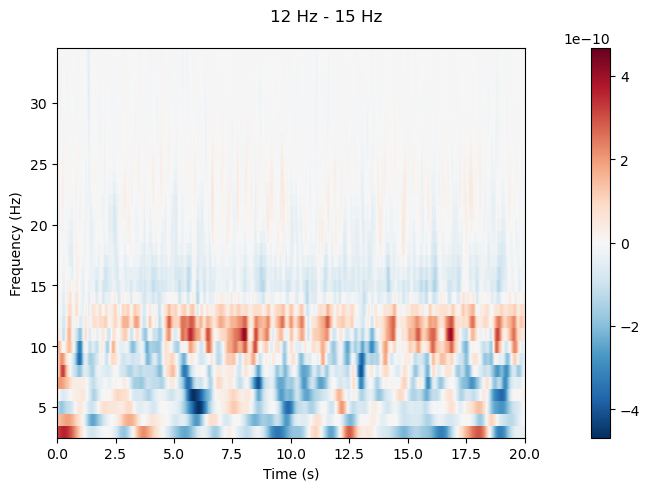

[<Figure size 640x480 with 2 Axes>]

In [56]:
power_difference_picks.plot(title="12 Hz - 15 Hz", tmin=0, tmax=20, combine="mean")

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 10 events and 5041 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


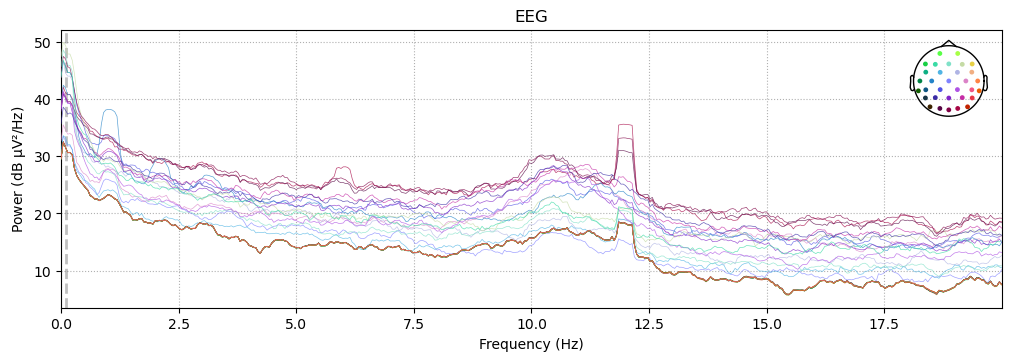

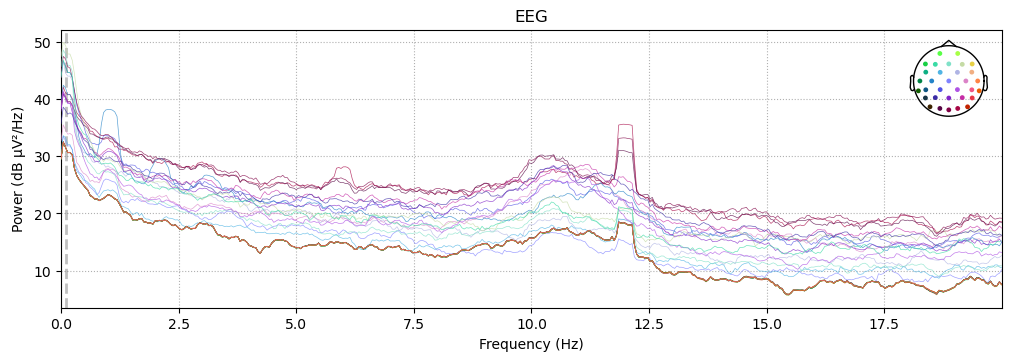

In [57]:
epochs_12hz.plot_psd(fmin=0, fmax=20)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 10 events and 5041 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/opt/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


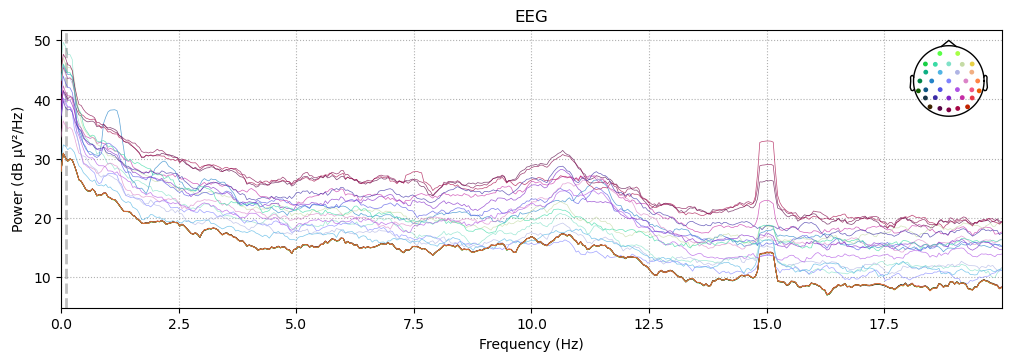

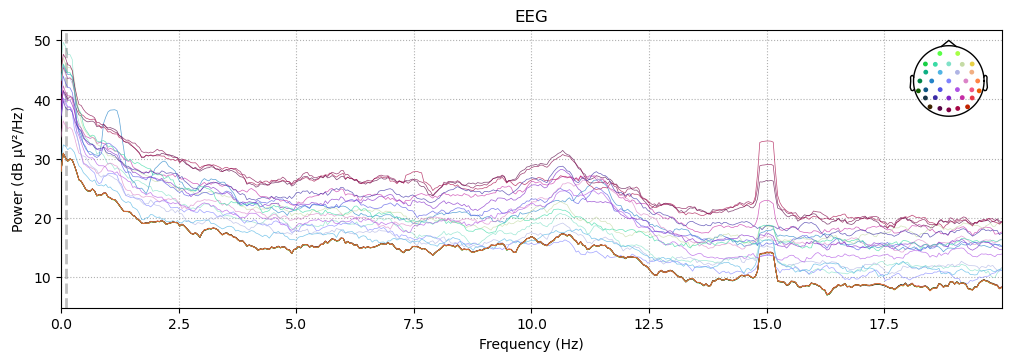

In [58]:
epochs_15hz.plot_psd(fmin=0, fmax=20)

# Source Estimation

https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

In [ ]:
# load inverse operator
inverse_operator_file = (
sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)

# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2

aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator, lambda2=lambda2, method="MNE") # or dSPM, sLORETA, eLORETA

# path to subjects' MRI files
subjects_dir = sample_data_folder / "subjects"

# plot the STC
stc.plot(
initial_time=0.1, hemi="split", views=["lat", "med"], subjects_dir=subjects_dir
)

# MNE-BIDS

In [ ]:
# Standard library imports
import os.path as op

# Third-party imports
import mne
from mne.channels import make_standard_montage
from mne_bids import BIDSPath, write_raw_bids

# Subject number - CHANGE to the file you want to convert to bids
sub_num = "35"
data_path = "directory" # CHANGE to the path where the data is stored
raw_fname = op.join(data_path, "file name") # CHANGE to the file name

raw = mne.io.read_raw_brainvision(raw_fname)
# Define the correct montage for the data available in MNE
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Check available event keys and if you need to make new ones 
events, _ = mne.events_from_annotations(raw, verbose=False)
print(raw.annotations)

# Define new keys for event IDs - these ones provide a more detailed description of the events
mapping = {
    # current
    "encoding/current/1": 111,
    "encoding/current/2": 121,
    "encoding/current/3": 131,
    "encoding/current/4": 141,
    
    # define others
	
}

# remove annotations so I can fill the event_id-s with descriptions
raw.set_annotations(None)

# set a new root path for the bidsyfied files
new_path = "new_directory"
# change subject number here:
bids_root = op.join(new_path)

# Datatype might also be inferred automatically, but it's safer to specify it
bids_path = BIDSPath(
    subject=sub_num,
    datatype="eeg", 
    task="instract", 
    root=bids_root
)
# Add extensions to the path
bids_path.update(suffix="eeg", extension=".vhdr")
# Power line frequency missing in raw.info
raw.info["line_freq"] = 50  # required by BIDS. 50Hz in Spain

# Create bids structure for first participant
write_raw_bids(
    raw,
    bids_path=bids_path,
    events=events,
    event_id=mapping,
    overwrite=True,
    verbose=True,
)